# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

本节将根据 :numref:`sec_rnn`中的描述，
从头开始基于循环神经网络实现字符级语言模型。
这样的模型将在H.G.Wells的时光机器数据集上训练。
和前面 :numref:`sec_language_model`中介绍过的一样，
我们先读取数据集。


In [32]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from myd2l import torch as d2l

In [33]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**独热编码**]

回想一下，在`train_iter`中，每个词元都表示为一个数字索引，
将这些索引直接输入神经网络可能会使学习变得困难。
我们通常将每个词元表示为更具表现力的特征向量。
最简单的表示称为*独热编码*（one-hot encoding），
它在 :numref:`subsec_classification-problem`中介绍过。

简言之，将每个索引映射为相互不同的单位向量：
假设词表中不同词元的数目为$N$（即`len(vocab)`），
词元索引的范围为$0$到$N-1$。
如果词元的索引是整数$i$，
那么我们将创建一个长度为$N$的全$0$向量，
并将第$i$处的元素设置为$1$。
此向量是原始词元的一个独热向量。
索引为$0$和$2$的独热向量如下所示：


In [34]:
F.one_hot(torch.tensor([0, 2]), len(vocab))
# len(vocab)  = 28
# def load_corpus_time_machine(max_tokens=-1):  中定义
# tokens = tokenize(lines, 'char') 
# 加上空格和reserve_tokens就是28

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的**小批量数据形状是二维张量：
（批量大小，时间步数）。**
`one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小（`len(vocab)`）。因为onehot函数的格式就是tensor(`len(vocab)`,)
我们经常转换输入的维度，以便获得形状为
（时间步数，批量大小，词表大小）的输出。
这将使我们能够更方便地通过最外层的维度，
一步一步地更新小批量数据的隐状态。


In [35]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape
# 为什么要转置
# RNN 的循环是“沿时间步走”的，所以更自然的布局是时间在最外层

torch.Size([5, 2, 28])

## 初始化模型参数

接下来，我们[**初始化循环神经网络模型的模型参数**]。
隐藏单元数`num_hiddens`是一个可调的超参数。
当训练语言模型时，输入和输出来自相同的词表。
因此，它们具有相同的维度，即词表的大小。


In [36]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 循环神经网络模型

为了定义循环神经网络模型，
我们首先需要[**一个`init_rnn_state`函数在初始化时返回隐状态**]。
这个函数的返回是一个张量，张量全用0填充，
形状为（批量大小，隐藏单元数）。
在后面的章节中(LSTM包含长期和短期记忆)我们将会遇到隐状态包含多个变量的情况，
而使用元组可以更容易地处理些。


In [37]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

[**下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出。**]
循环神经网络模型通过`inputs`最外层的维度实现循环，
以便逐时间步更新小批量数据的隐状态`H`。
此外，这里使用$\tanh$函数作为激活函数。
如 :numref:`sec_mlp`所述，
当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [38]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    # state是一个tuple，为了和非tuple做区分，因此需要再传入H之后加入一个空的元素，组成一个tuple
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) # 开头的H应该是当前时刻的H，即H_{t}， 
                       + torch.mm(H, W_hh) # 此处的H应该是前一时刻的H，即H_{t-1}，
                       + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)
# concatenate之后从三维矩阵变成了二维矩阵，因为拼接是在dim=0，
# 因此列数没变，行数变成了time_step * batch_size
# return (H,) 输出更新后的隐藏状态

定义了所有需要的函数之后，接下来我们[**创建一个类来包装这些函数**]，
并存储从零开始实现的循环神经网络模型的参数。


In [39]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们[**检查输出是否具有正确的形状**]。
例如，隐状态的维数是否保持不变。


In [40]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数$\times$批量大小，词表大小），
而隐状态形状保持不变，即（批量大小，隐藏单元数）。

## 预测

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，
其中的`prefix`是一个用户提供的包含多个字符的字符串。
在循环遍历`prefix`中的开始字符时，
我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。
这被称为*预热*（warm-up）期，
因为在此期间模型会自我更新（例如，更新隐状态），
但不会进行预测。
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
从而预测字符并输出它们。


In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    # vocab[prefix[0]]：将第一个字符映射为索引（如 'h' → 7）
    # outputs 存储所有已生成 token 的索引（包括 prefix 和新生成部分）
    # ⚠️ 注意：这里只加了第一个字符！后续字符通过“预热”逐步加入
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    # 为什么需要预热？
    # RNN 的隐藏状态 state 需要“看到”整个 prefix 才能合理预测后续
    # 但 outputs 初始只有 prefix[0]，所以要逐步喂入剩余字符
    # ✅ 关键点：预热期不使用模型预测结果，而是强制用真实 prefix 字符更新状态！
    # 这确保隐藏状态 state 编码了完整上下文 "abc"。
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
        
    # “在接下来的 num_preds 步中，每一步都：
    # 将上一步生成的 token 索引（通过 get_input() 获取）作为当前输入；
    # 将上一时刻的隐藏状态传入 RNN；
    # RNN 返回当前时间步的输出 logits y 和更新后的隐藏状态 state；
    # 通过对 y 进行 argmax（贪婪解码），得到概率最大的下一个 token 的索引；
    # 将该索引追加到 outputs 列表末尾。” 
    # 关键：这一步只处理索引；最后才统一用 vocab.idx_to_token 转回字符。
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# ''.join(list) 是 Python 中将字符串列表拼接成一个字符串的标准方法
# 引号中的内容是分隔符
# '' 表示无分隔符（直接拼接）
# ',' 会得到 'c,d,e'
# ' ' 会得到 'c d e'
# 为什么用 ''？
# 因为我们在做字符级语言模型，目标是生成连续文本，如 "hello"，而不是 "h e l l o"。

我们来**逐行、逐句、逐操作**地详细展开这段代码：

```python
for y in prefix[1:]:  # 预热期
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
```

这是整个文本生成函数 `predict_ch8` 中最关键的“**预热**（warm-up）”阶段。
它的目标是：**让 RNN 的隐藏状态 `state` 正确地“看到”并编码整个前缀 `prefix`，为后续的自回归生成做好准备**。

---
🔍 第一步：理解循环结构

```python
for y in prefix[1:]:
```

- **`prefix`** 是一个字符串，比如 `"hello"`
- **`prefix[1:]`** 表示从第 2 个字符开始到末尾 → `"ello"`
- **`y`** 在每次循环中取一个字符：
  - 第1轮：`y = 'e'`
  - 第2轮：`y = 'l'`
  - 第3轮：`y = 'l'`
  - 第4轮：`y = 'o'`

> ✅ **为什么从 `prefix[1:]` 开始？**  
> 因为 `prefix[0]`（即 `'h'`）已经在前面被加入 `outputs` 了：
> ```python
> outputs = [vocab[prefix[0]]]   # ← 已处理第一个字符
> ```
> 所以这里只需处理剩下的字符。


🔍 第二步：获取当前输入

```python
get_input()
```

这是一个之前定义的 lambda 函数：

```python
get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
```

它的作用是：
- 取 `outputs` 列表的**最后一个元素**（即最新 token 的索引）
- 构造一个形状为 `(1, 1)` 的张量（batch_size=1, num_steps=1）

举个例子（在循环中）：
| 循环轮次 | 当前 `outputs`         | `outputs[-1]` | `get_input()` 返回张量 |
|--------|------------------------|---------------|------------------------|
| 初始   | `[vocab['h']]` → `[7]` | `7`           | `tensor()`        |
| 第1轮  | `[7]`                  | `7`           | `tensor()`        |
| 第2轮  | `[7, vocab['e']]`      | `vocab['e']`  | `tensor([[vocab['e']]])` |

> 💡 注意：**在预热期，输入始终是“真实历史字符”的索引**，而不是模型预测的结果！


🔍 第三步：RNN 前向传播（**但丢弃输出**）

```python
_, state = net(get_input(), state)
```

- `net` 是 RNN 模型（如 `RNNModel`），其前向函数通常返回 `(output, new_state)`
- **`_`**：表示丢弃输出，我们**不关心模型此刻的输出**（即对下一个字符的预测）
- **`state`**：传入旧状态，接收更新后的状态

为什么丢弃输出？
因为在**预热阶段，我们的目标不是生成新字符，而是“喂入”真实前缀来初始化隐藏状态**。

> 🧠 类比：就像你读一句话的前半部分来理解上下文，但还没开始续写。

内部发生了什么？
假设 RNN 是简单 RNN：
```python
h_t = tanh( W_xh @ x_t + W_hh @ h_{t-1} + b_h )
```
- `x_t = get_input()` → 当前字符的 one-hot 或 embedding
- `h_{t-1} = state` → 上一时刻的隐藏状态
- 计算出新的 `h_t` → 更新 `state`

这样，每轮循环后，`state` 就包含了更多前缀信息。


🔍 第四步：将真实字符加入 outputs

```python
outputs.append(vocab[y])
```

- `y` 是当前循环的真实字符（来自 `prefix[1:]`）
- `vocab[y]` 将其转换为索引（如 `'e' → 42`）
- 把这个索引追加到 `outputs` 列表末尾

为什么这么做？
1. **保持 `outputs` 与实际输入一致**  
   `outputs` 必须完整记录“到目前为止所有已处理的 token”，因为 `get_input()` 依赖它取最后一个 token。
   
2. **为后续生成阶段提供正确的起始点**  
   生成阶段的第一步输入就是 `prefix` 的最后一个字符。

示例流程（`prefix = "hi"`）：

| 步骤 | `outputs` 初始值 | 循环中 `y` | `vocab[y]` | `outputs` 更新后 |
|------|------------------|-----------|------------|------------------|
| 初始化 | `[vocab['h']]` → `[7]` | — | — | `[7]` |
| 第1轮 | `[7]` | `'i'` | `8` | `[7, 8]` |

现在 `outputs = [7, 8]`，对应 `"hi"`，且 RNN 的 `state` 已经编码了 `"hi"` 的上下文。


🎯 总结：这三行代码的完整逻辑链

| 代码行 | 作用 | 为什么必要 |
|-------|------|----------|
| `for y in prefix[1:]:` | 遍历前缀中除首字符外的所有字符 | 首字符已处理，需补充剩余部分 |
| `_, state = net(get_input(), state)` | 用真实字符更新 RNN 隐藏状态 | 让模型“理解”当前上下文 |
| `outputs.append(vocab[y])` | 将真实字符索引加入输出列表 | 确保下一步输入正确，保持序列完整 |

> ✅ **核心目的**：  
> **在不进行任何预测的情况下，将整个 `prefix` “注入” RNN 的隐藏状态，使其处于一个合理的上下文感知状态，从而为后续的自回归生成打下基础**。


现在我们可以测试`predict_ch8`函数。
我们将前缀指定为`time traveller `，
并基于这个前缀生成10个后续字符。
鉴于我们还没有训练网络，它会生成荒谬的预测结果。


In [42]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller feyib<unk>l<unk>fe'

## [**梯度裁剪**]

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，
将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。
如 :numref:`sec_numerical_stability`所述，
当$T$较大时，它可能导致数值不稳定，
例如可能导致梯度爆炸或梯度消失。
因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤。
假定在向量形式的$\mathbf{x}$中，
或者在小批量数据的负梯度$\mathbf{g}$方向上。
例如，使用$\eta > 0$作为学习率时，在一次迭代中，
我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。
如果我们进一步假设目标函数$f$表现良好，
即函数$f$在常数$L$下是*利普希茨连续的*（Lipschitz continuous）。
也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以安全地假设：
如果我们通过$\eta \mathbf{g}$更新参数向量，则

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。
这既是坏事也是好事。
坏的方面，它限制了取得进展的速度；
好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。
我们可以通过降低$\eta$的学习率来解决这个问题。
但是如果我们很少得到大的梯度呢？
在这种情况下，这种做法似乎毫无道理。
一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径
（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。
如下式：

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

通过这样做，我们知道梯度范数永远不会超过$\theta$，
并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。
它还有一个值得拥有的副作用，
即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，
这赋予了模型一定程度的稳定性。
梯度裁剪提供了一个快速修复梯度爆炸的方法，
虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，
模型是从零开始实现的模型或由高级API构建的模型。
我们在此计算了所有模型参数的梯度的范数。


In [12]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。
它与我们训练 :numref:`sec_softmax_scratch`模型的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity`所述，
   这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在每个迭代周期的开始位置初始化隐状态。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态。
这样，存储在隐状态中的序列的历史信息
可以在一个迭代周期内流经相邻的子序列。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得复杂。
为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。
与 :numref:`sec_softmax_scratch`中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。


In [13]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

你问的是 `y.long()`（注意是 `.long()`，不是 `.lonng()`，可能是拼写笔误）。

这是 **PyTorch 中的一个张量类型转换方法**，作用是：  
> **将张量 `y` 的数据类型（dtype）转换为 64 位有符号整数**（`torch.int64`）

---

### 🔍 详细解释

#### 1. **为什么需要 `.long()`？**
在 PyTorch 中，**某些操作对输入的数据类型有严格要求**。最典型的就是：

> ✅ **`nn.CrossEntropyLoss` 要求标签**（target）

如果你的标签 `y` 是：
- `float32`（如 `torch.float`）
- `int32`（如 `torch.int`）

那么直接传给 `CrossEntropyLoss` 会报错！

#### 示例错误：
```python
loss_fn = nn.CrossEntropyLoss()
y_hat = torch.randn(2, 5)          # logits, shape (2,5)
y = torch.tensor([1, 2])           # 默认 dtype 可能是 int64（没问题）
# 但如果 y 是 float:
y = torch.tensor([1.0, 2.0])       # dtype=torch.float32
loss_fn(y_hat, y)  # ❌ RuntimeError: expected scalar type Long but found Float
```

✅ 解决方案：
```python
loss_fn(y_hat, y.long())  # ✅ 正确！
```

---

#### 2. **`.long()` 等价于什么？**
```python
y.long()  ≡  y.to(torch.int64)  ≡  y.type(torch.LongTensor)
```

| 方法 | 说明 |
|------|------|
| `y.long()` | 最常用、最简洁 |
| `y.to(torch.int64)` | 更通用（可转任意类型） |
| `y.type(...)` | 较老式，不推荐 |

---

#### 3. **在你的代码上下文中**
```python
y = Y.T.reshape(-1)        # y 可能是 int32 或 float（取决于数据加载方式）
l = loss(y_hat, y.long()).mean()  # 强制转为 long，满足 CrossEntropyLoss 要求
```

即使 `y` 已经是整数类型（如 `int32`），也**必须转为 `int64`**，因为 PyTorch 的分类损失函数**硬性规定标签必须是 `LongTensor`**。

> 💡 这是 PyTorch 的设计约定，源于底层 C++ 实现的效率考虑。

---

### 🧪 小实验验证
```python
import torch
import torch.nn as nn

y = torch.tensor([1, 2, 3])      # 默认 dtype=torch.int64 → 没问题
print(y.dtype)                   # torch.int64

y2 = torch.tensor([1, 2, 3], dtype=torch.int32)
print(y2.dtype)                  # torch.int32

loss_fn = nn.CrossEntropyLoss()
logits = torch.randn(3, 5)

# 这会报错！
# loss_fn(logits, y2)  # ❌ Expected Long, got Int

# 这样才行：
loss_fn(logits, y2.long())       # ✅ 正确
```

---

### ✅ 总结

| 问题 | 答案 |
|------|------|
| `y.long()` 是什么意思？ | 将张量 `y` 转换为 `torch.int64` 类型 |
| 为什么要用它？ | **PyTorch 的分类损失函数**（如 `CrossEntropyLoss`） |
| 不用会怎样？ | **运行时错误**：`expected scalar type Long but found XXX` |
| 其他类似方法？ | `.float()`, `.double()`, `.half()` 等用于类型转换 |

> 🎯 **记住这个黄金法则**：  
> **模型输出**（logits） → **float32**  
> **真实标签**（labels） → **long**（int64）

你现在完全理解了 `.long()` 的作用和必要性！

[**循环神经网络模型的训练函数既支持从零开始实现，
也可以使用高级API来实现。**]


In [14]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

[**现在，我们训练循环神经网络模型。**]
因为我们在数据集中只使用了10000个词元，
所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 43766.4 词元/秒 cuda:0
time traveller fit so stallng ofuthacisand an anory the time tra
traveller with a slight accession ofcheerfulness really thi


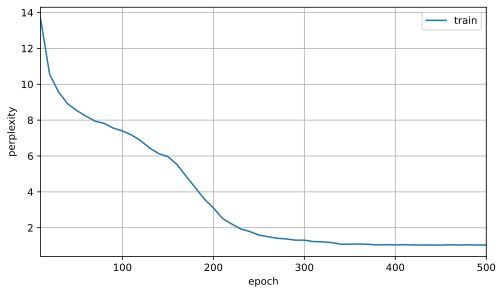

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

[**最后，让我们检查一下使用随机抽样方法的结果。**]


困惑度 1.5, 38111.9 词元/秒 cuda:0
time traveller smiled rous thones that space as our mathematicia
traveller came back andfilby trieg think so mingus not has 


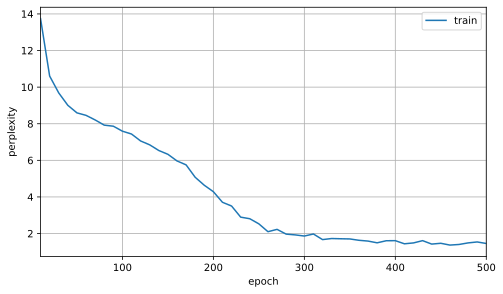

In [17]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

从零开始实现上述循环神经网络模型，
虽然有指导意义，但是并不方便。
在下一节中，我们将学习如何改进循环神经网络模型。
例如，如何使其实现地更容易，且运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 困惑度可以降到多少？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 如果用H.G.Wells的其他书作为数据集时效果如何，
      例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2103)
